In [1]:
# imports files
import zipfile
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, precision_recall_curve,
    roc_auc_score, fbeta_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ZIP_PATH = "flights.csv.zip"
AIRLINES_PATH = "airlines.csv"
AIRPORTS_PATH = "airports.csv"

In [3]:
airlines = pd.read_csv(AIRLINES_PATH)  # IATA_CODE, AIRLINE
airports = pd.read_csv(AIRPORTS_PATH)  # IATA_CODE, AIRPORT, CITY, STATE, ...
airlines.head(), airports.head()

(  IATA_CODE                 AIRLINE
 0        UA   United Air Lines Inc.
 1        AA  American Airlines Inc.
 2        US         US Airways Inc.
 3        F9  Frontier Airlines Inc.
 4        B6         JetBlue Airways,
   IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
 0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
 1       ABI             Abilene Regional Airport      Abilene    TX     USA   
 2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
 3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
 4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   
 
    LATITUDE  LONGITUDE  
 0  40.65236  -75.44040  
 1  32.41132  -99.68190  
 2  35.04022 -106.60919  
 3  45.44906  -98.42183  
 4  31.53552  -84.19447  )

In [4]:
# Inspect once, then lock the schema
with zipfile.ZipFile(ZIP_PATH) as z:
    with z.open("flights.csv") as f:
        sample = pd.read_csv(f, nrows=2000)

sample.columns.tolist()

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

In [5]:
# Categorize columns by PURPOSE
IDENTIFIERS = [
    "AIRLINE","FLIGHT_NUMBER","TAIL_NUMBER"
]

TIME_FEATURES = [
    "YEAR","MONTH","DAY","DAY_OF_WEEK",
    "SCHEDULED_DEPARTURE","SCHEDULED_ARRIVAL"
]

ROUTE_FEATURES = [
    "ORIGIN_AIRPORT","DESTINATION_AIRPORT","DISTANCE"
]

TARGET_RELATED = [
    "ARRIVAL_DELAY","DEPARTURE_DELAY","CANCELLED","DIVERTED"
]

DELAY_CAUSES = [
    "AIR_SYSTEM_DELAY","SECURITY_DELAY",
    "AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"
]

use_cols = (
    IDENTIFIERS +
    TIME_FEATURES +
    ROUTE_FEATURES +
    TARGET_RELATED +
    DELAY_CAUSES
)

In [6]:
# Explicit dtypes for memory efficiency, consistency, and reproducibility
# Categorical columns are stored as 'category' to reduce memory footprint
# and speed up groupby/encoding operations.
# Numeric types are downcast to the smallest safe integer/float type
# to avoid unnecessary memory usage on large flight datasets.
# Time columns are read as strings intentionally and parsed later to
# allow controlled feature engineering (e.g., hour, peak/off-peak).

dtypes = {
    # Airline and route identifiers (categorical, low cardinality)
    "AIRLINE": "category",
    "ORIGIN_AIRPORT": "category",
    "DESTINATION_AIRPORT": "category",

    # Flight identifiers (not used for modeling, kept for traceability)
    "FLIGHT_NUMBER": "Int64",      # nullable integer
    "TAIL_NUMBER": "string",       # aircraft identifier

    # Calendar features (small integer types are sufficient)
    "YEAR": "int16",
    "MONTH": "int8",
    "DAY": "int8",
    "DAY_OF_WEEK": "int8",

    # Scheduled times read as strings and converted later
    # to avoid parsing issues and enable custom time features
    "SCHEDULED_DEPARTURE": "string",
    "SCHEDULED_ARRIVAL": "string",

    # Route distance (miles) – bounded, fits in int16
    "DISTANCE": "int16",

    # Delay measurements (continuous, may contain NaNs)
    "DEPARTURE_DELAY": "float32",
    "ARRIVAL_DELAY": "float32",

    # Binary operational flags
    "CANCELLED": "int8",
    "DIVERTED": "int8",

    # Delay cause breakdowns (continuous, sparse)
    "AIR_SYSTEM_DELAY": "float32",
    "SECURITY_DELAY": "float32",
    "AIRLINE_DELAY": "float32",
    "LATE_AIRCRAFT_DELAY": "float32",
    "WEATHER_DELAY": "float32"
}

In [7]:
# Read the large flights dataset in chunks to avoid loading everything
# into memory at once and to keep the process scalable.
chunks = []
chunksize = 300_000

# Open the zipped CSV directly to avoid extracting the full file
with zipfile.ZipFile(ZIP_PATH) as z:
    with z.open("flights.csv") as f:
        # Read only the required columns with explicit dtypes
        # to reduce memory usage and ensure consistent schema
        for chunk in pd.read_csv(
            f,
            usecols=use_cols,
            dtype=dtypes,
            chunksize=chunksize
        ):
            # Filter early to keep only Delta Airlines flights
            # This reduces memory usage and speeds up downstream processing
            chunk = chunk.query("AIRLINE == 'DL'")
            chunks.append(chunk)

# Combine all Delta-only chunks into a single DataFrame
dl = pd.concat(chunks, ignore_index=True)

# Final dataset shape after filtering and concatenation
dl.shape

(875881, 21)

In [8]:
# Keep only non-cancelled/non-diverted for delay modeling
df = dl[(dl["CANCELLED"] == 0) & (dl["DIVERTED"] == 0)].copy()
# Remove rows where target cannot be determined
df = df[df["ARRIVAL_DELAY"].notna()].copy()

# Create binary target
df["delay_flag"] = (df["ARRIVAL_DELAY"] > 15).astype(int)
# Target: DOT-style delay definition
DELAY_THRESHOLD = 15
df["delay_flag"] = (df["ARRIVAL_DELAY"] > DELAY_THRESHOLD).astype(int)

print("Rows (modeling):", df.shape[0])
print("Delay rate:", df["delay_flag"].mean(), f"({df['delay_flag'].mean()*100:.2f}%)")
df[["ARRIVAL_DELAY","DEPARTURE_DELAY","delay_flag"]].head()

Rows (modeling): 870275
Delay rate: 0.12997270977564562 (13.00%)


,ARRIVAL_DELAY,DEPARTURE_DELAY,delay_flag
0,8.0,-5.0,0
1,-15.0,3.0,0
2,-30.0,-6.0,0
3,-4.0,0.0,0
4,-22.0,-6.0,0


In [9]:
# Convert scheduled times from HHMM format into minutes since midnight.
# This makes time values numeric, easier to model, and more interpretable.
def hhmm_to_minutes(x):
    if pd.isna(x):
        return np.nan
    try:
        # Handle values like "700", "0700", or "700.0"
        x = int(float(x))
        hh = x // 100
        mm = x % 100

        # Validate hour and minute ranges
        if hh < 0 or hh > 23 or mm < 0 or mm > 59:
            return np.nan

        return hh * 60 + mm
    except:
        # Gracefully handle malformed time values
        return np.nan

# Scheduled departure and arrival times in minutes
df["sched_dep_min"] = df["SCHEDULED_DEPARTURE"].apply(hhmm_to_minutes)
df["sched_arr_min"] = df["SCHEDULED_ARRIVAL"].apply(hhmm_to_minutes)

# Extract departure hour for time-of-day analysis
df["sched_dep_hour"] = (df["sched_dep_min"] // 60).astype("Int64")

# Flag peak travel hours based on airline operations patterns
# Morning and evening peaks typically experience higher congestion
df["is_peak_hour"] = df["sched_dep_hour"].isin([6, 7, 8, 9, 16, 17, 18, 19]).astype(int)

# Quick sanity check of engineered time features
df[[
    "SCHEDULED_DEPARTURE",
    "sched_dep_min",
    "sched_dep_hour",
    "is_peak_hour"
]].head()

,SCHEDULED_DEPARTURE,sched_dep_min,sched_dep_hour,is_peak_hour
0,0025,25,0,0
1,0030,30,0,0
2,0030,30,0,0
3,0035,35,0,0
4,0040,40,0,0


In [10]:
# Define major Delta hub airports.
# Hub airports tend to have higher traffic density and operational complexity,
# which can influence congestion and delay patterns.
DELTA_HUBS = {"ATL", "DTW", "MSP", "JFK", "LGA", "SLC", "SEA", "BOS"}

# Flag whether the flight originates from a Delta hub
df["is_origin_hub"] = df["ORIGIN_AIRPORT"].isin(DELTA_HUBS).astype(int)

# Flag whether the flight arrives at a Delta hub
df["is_dest_hub"] = df["DESTINATION_AIRPORT"].isin(DELTA_HUBS).astype(int)

# Sanity check to verify hub indicators
df[[
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "is_origin_hub",
    "is_dest_hub"
]].head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,is_origin_hub,is_dest_hub
0,SFO,MSP,0,1
1,LAS,ATL,0,1
2,DEN,ATL,0,1
3,LAX,MSP,0,1
4,SLC,ATL,1,1


In [11]:
# Create a route-level feature by combining origin and destination airports.
# This captures route-specific delay patterns (e.g., consistently congested
# city pairs) that may not be visible when airports are considered separately.
df["route"] = (
    df["ORIGIN_AIRPORT"].astype(str) + "_" +
    df["DESTINATION_AIRPORT"].astype(str)
)

# Quick check of generated route identifiers
df["route"].head()

,route
0,SFO_MSP
1,LAS_ATL
2,DEN_ATL
3,LAX_MSP
4,SLC_ATL


In [12]:
# Columns that would cause target leakage if used as predictors.
# These fields are either the target itself or post-event delay
# explanations that are only known after the flight outcome.
LEAKAGE_COLS = [
    "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]

# Numeric features that are known before departure and relevant
# for operational delay prediction.
BASE_FEATURES_NUM = [
    "YEAR",
    "MONTH",
    "DAY_OF_WEEK",
    "DISTANCE",
    "sched_dep_min",
    "sched_arr_min",
    "sched_dep_hour",
    "is_peak_hour",
    "is_origin_hub",
    "is_dest_hub"
]

# Categorical features capturing route and airport effects
BASE_FEATURES_CAT = [
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "route"
]

# Departure delay is not available before pushback.
# It is excluded by default to avoid leakage, but can be optionally
# included if modeling arrival delay conditional on departure delay.
USE_DEPARTURE_DELAY = False
if USE_DEPARTURE_DELAY:
    BASE_FEATURES_NUM.append("DEPARTURE_DELAY")

# Drop leakage-prone columns to ensure predictors reflect
# only information available at prediction time
df_model = df.drop(
    columns=[c for c in LEAKAGE_COLS if c in df.columns],
    errors="ignore"
).copy()

# Final feature matrix (X) and target vector (y)
X = df_model[BASE_FEATURES_NUM + BASE_FEATURES_CAT].copy()
y = df_model["delay_flag"].copy()

# Sanity check: feature dimensions and class imbalance
X.shape, y.mean()

((870275, 13), np.float64(0.12997270977564562))

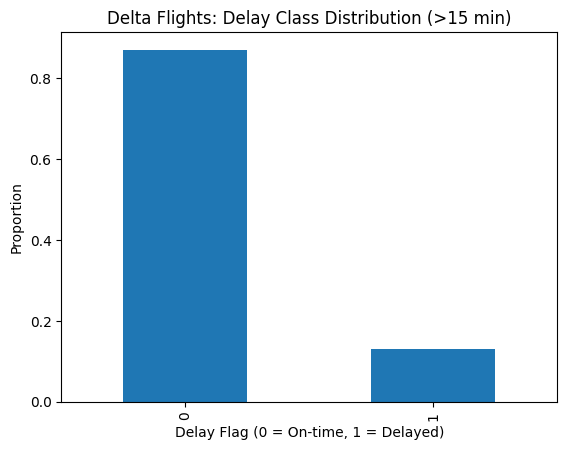

In [13]:
# Visualize the class distribution of the target variable.
# This helps confirm class imbalance and guides metric selection
# and threshold tuning strategy for the model.
df["delay_flag"].value_counts(normalize=True).plot(kind="bar")

plt.title("Delta Flights: Delay Class Distribution (>15 min)")
plt.ylabel("Proportion")
plt.xlabel("Delay Flag (0 = On-time, 1 = Delayed)")

plt.show()

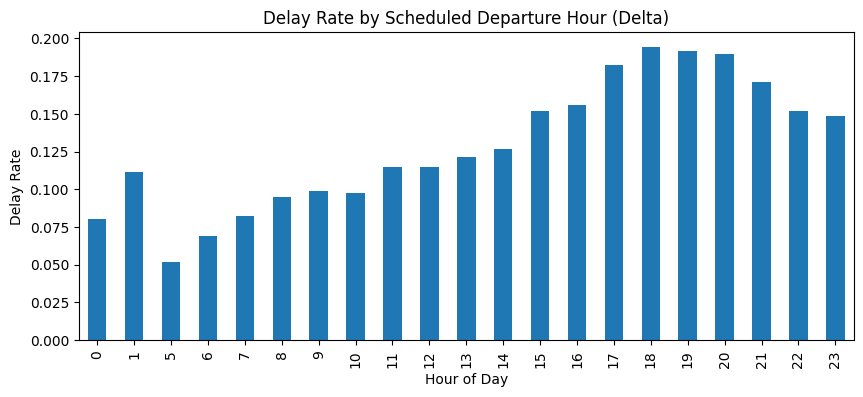

In [14]:
# Analyze how delay rates vary by scheduled departure hour.
# This helps identify time-of-day effects such as morning and evening
# congestion peaks, which are common in airline operations.
hourly_delay = df.groupby("sched_dep_hour")["delay_flag"].mean()

plt.figure(figsize=(10, 4))
hourly_delay.plot(kind="bar")

plt.title("Delay Rate by Scheduled Departure Hour (Delta)")
plt.ylabel("Delay Rate")
plt.xlabel("Hour of Day")

plt.show()

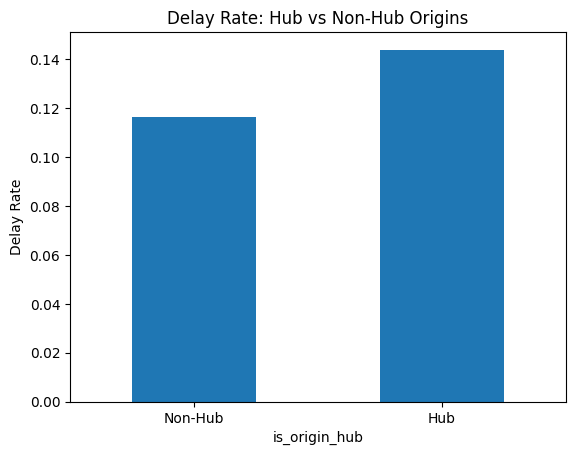

In [15]:
# Compare delay rates for flights departing from hub vs non-hub airports.
# Hub airports typically handle higher traffic volumes and tighter schedules,
# which can lead to increased congestion and higher delay rates.
hub_delay = df.groupby("is_origin_hub")["delay_flag"].mean()

hub_delay.plot(kind="bar")

plt.title("Delay Rate: Hub vs Non-Hub Origins")
plt.xticks([0, 1], ["Non-Hub", "Hub"], rotation=0)
plt.ylabel("Delay Rate")

plt.show()

/tmp/ipython-input-505666812.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_bucket")["delay_flag"].mean().plot(kind="bar")


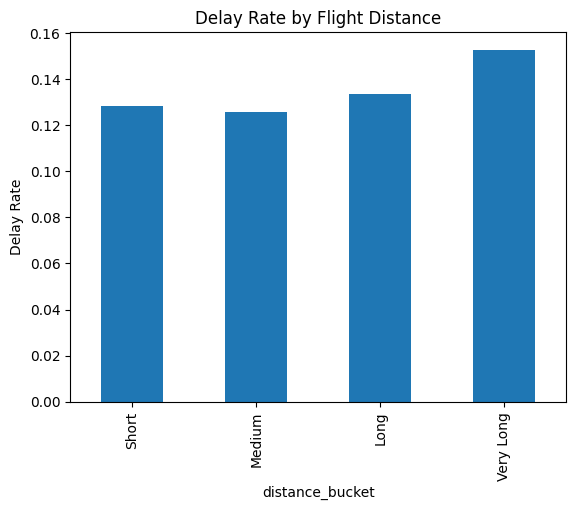

In [16]:
# Bucket flights by distance to analyze how delay rates vary
# across short-, medium-, and long-haul routes.
# Distance can influence delays due to factors such as
# aircraft rotation, crew duty limits, and weather exposure.
df["distance_bucket"] = pd.cut(
    df["DISTANCE"],
    bins=[0, 500, 1000, 2000, 5000],
    labels=["Short", "Medium", "Long", "Very Long"]
)

# Compare average delay rates across distance categories
df.groupby("distance_bucket")["delay_flag"].mean().plot(kind="bar")

plt.title("Delay Rate by Flight Distance")
plt.ylabel("Delay Rate")

plt.show()

In [17]:
# Split the data into train, validation, and test sets.
# Stratification ensures the delay class distribution is preserved
# across all splits, which is important given class imbalance.
# The validation set is used for threshold tuning and model selection,
# while the test set is held out for final, unbiased evaluation.

# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Sanity check: confirm similar delay rates across splits
print("Train delay rate:", y_train.mean())
print("Val delay rate  :", y_val.mean())
print("Test delay rate :", y_test.mean())

Train delay rate: 0.12997232675495293
Val delay rate  : 0.12997615696187986
Test delay rate : 0.12997041165148948


In [18]:
# Identify categorical and numerical feature columns.
# This allows different preprocessing steps to be applied
# to each feature type in a controlled and reproducible way.
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Numeric preprocessing pipeline:
# - Impute missing values using the median (robust to skew)
# - Scale features to support stable convergence of linear models
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing pipeline:
# - Replace missing values with an explicit "UNKNOWN" category
# - One-hot encode with frequency thresholding to control cardinality
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", min_frequency=50))
])

# Combine numeric and categorical pipelines into a single transformer.
# This ensures preprocessing is applied consistently across train,
# validation, and test sets without data leakage.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ]
)

In [19]:
# Train a Logistic Regression model as an interpretable baseline.
# Logistic Regression provides a strong, transparent starting point
# for understanding key drivers of flight delays.

from sklearn.linear_model import LogisticRegression

# Configure the model to handle class imbalance by weighting
# the minority (delayed) class more heavily.
log_reg = LogisticRegression(
    max_iter=300,
    class_weight="balanced"
)

# Combine preprocessing and model into a single pipeline.
# This ensures that all transformations are learned only from
# the training data and applied consistently to all splits.
log_pipe = Pipeline([
    ("prep", preprocess),
    ("model", log_reg)
])

# Fit the pipeline on the training set
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEAR', 'MONTH',
                                                   'DAY_OF_WEEK', 'DISTANCE',
                                                   'sched_dep_min',
                                                   'sched_arr_min',
                                                   'sched_dep_hour',
                                                   'is_peak_hour',
                                                   'is_origin_hub',
                                                   'is_dest_hub']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=50))]),
                                                  ['ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT',
                                                   'route'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=300))])

In [20]:
# Train a Random Forest model to capture non-linear relationships
# and interactions between features such as route, time of day,
# and hub effects that a linear model may miss.
from sklearn.ensemble import RandomForestClassifier

# Configure the Random Forest with a moderate depth to balance
# model expressiveness and overfitting, and apply class weighting
# to address class imbalance.
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees for stable performance
    max_depth=12,            # limit depth to reduce overfitting
    class_weight="balanced", # handle minority delay class
    random_state=42,         # reproducibility
    n_jobs=-1                # parallelize training
)

# Combine preprocessing and model into a single pipeline to ensure
# consistent feature transformations and avoid data leakage.
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", rf)
])

# Fit the Random Forest pipeline on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEAR', 'MONTH',
                                                   'DAY_OF_WEEK', 'DISTANCE',
                                                   'sched_dep_min',
                                                   'sched_arr_min',
                                                   'sched_dep_hour',
                                                   'is_peak_hour',
                                                   'is_origin_hub',
                                                   'is_dest_hub']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=50))]),
                                                  ['ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT',
                                                   'route'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [21]:
# Evaluate both models on the validation set using probability-based,
# threshold-independent metrics. This allows fair model comparison
# before choosing any decision threshold.

# Logistic Regression validation probabilities
log_val_proba = log_pipe.predict_proba(X_val)[:, 1]

# Random Forest validation probabilities
rf_val_proba = rf_pipe.predict_proba(X_val)[:, 1]

# ROC-AUC measures overall ranking ability across all thresholds
# PR-AUC is more informative here due to class imbalance
print("LOG REG  | ROC-AUC:", roc_auc_score(y_val, log_val_proba))
print("LOG REG  | PR-AUC :", average_precision_score(y_val, log_val_proba))

print("RF       | ROC-AUC:", roc_auc_score(y_val, rf_val_proba))
print("RF       | PR-AUC :", average_precision_score(y_val, rf_val_proba))

LOG REG  | ROC-AUC: 0.6460366178570256
LOG REG  | PR-AUC : 0.2167974408060926
RF       | ROC-AUC: 0.6451607584690429
RF       | PR-AUC : 0.22055857701492382


In [22]:
# Evaluate model performance across a range of classification thresholds.
# This function helps select an operating point that balances precision
# and recall based on business priorities, rather than relying on a fixed
# default threshold (e.g., 0.5).

def threshold_metrics(y_true, proba):
    rows = []

    # Sweep through a range of probability thresholds
    # to understand trade-offs between false positives and false negatives
    for t in np.linspace(0.05, 0.95, 19):
        preds = (proba >= t).astype(int)

        rows.append({
            # Decision threshold applied to predicted probabilities
            "threshold": t,

            # Precision: how many predicted delays are truly delayed
            # zero_division=0 avoids undefined values when no positives are predicted
            "precision": precision_score(y_true, preds, zero_division=0),

            # Recall: how many actual delays are correctly identified
            "recall": recall_score(y_true, preds, zero_division=0),

            # F1 score: balances precision and recall equally
            "F1": fbeta_score(y_true, preds, beta=1, zero_division=0),

            # F2 score: weights recall more heavily, appropriate when
            # missing a delay is more costly than a false alert
            "F2": fbeta_score(y_true, preds, beta=2, zero_division=0),
        })

    # Return threshold-level performance metrics as a DataFrame
    return pd.DataFrame(rows)

In [23]:
# Compute threshold-level performance metrics on the validation set
# for both models. This allows us to understand how each model behaves
# under different operating points before fixing a final threshold.

rf_thresh_df = threshold_metrics(y_val, rf_val_proba)
lr_thresh_df = threshold_metrics(y_val, log_val_proba)

# Inspect the top-performing thresholds for the Random Forest model
# based on F2 score, which prioritizes recall over precision.
rf_thresh_df.sort_values("F2", ascending=False).head()

,threshold,precision,recall,F1,F2
8,0.45,0.158742,0.814569,0.265704,0.446026
7,0.40,0.133732,0.985015,0.235492,0.433332
6,0.35,0.130056,0.999823,0.230172,0.427727
2,0.15,0.129976,1.000000,0.230051,0.427580
1,0.10,0.129976,1.000000,0.230051,0.427580


In [24]:
print("RF best F2:", rf_thresh_df["F2"].max())
print("LR best F2:", lr_thresh_df["F2"].max())

RF best F2: 0.44602575273501793
LR best F2: 0.4453793051202167


In [25]:
# Select the optimal decision threshold for the chosen model
# based on the validation set. The threshold is chosen to maximize
# the F2 score, reflecting a preference for higher recall when
# identifying delayed flights.

best_row = rf_thresh_df.sort_values("F2", ascending=False).iloc[0]
FINAL_THRESHOLD = best_row["threshold"]

# Inspect the selected operating point and the fixed threshold value
best_row, FINAL_THRESHOLD

(threshold    0.450000
 precision    0.158742
 recall       0.814569
 F1           0.265704
 F2           0.446026
 Name: 8, dtype: float64,
 np.float64(0.44999999999999996))

In [26]:
# Generate predicted probabilities on the held-out test set.
# No tuning is performed here; the model and threshold are already fixed.
rf_test_proba = rf_pipe.predict_proba(X_test)[:, 1]

# Apply the previously selected decision threshold to convert
# probabilities into final class predictions.
rf_test_preds = (rf_test_proba >= FINAL_THRESHOLD).astype(int)

# Evaluate final model performance on the test set.
# This provides an unbiased estimate of how the model would
# perform in a real deployment scenario.
print("\nCLASSIFICATION REPORT (TEST)")
print(classification_report(y_test, rf_test_preds, digits=3))


CLASSIFICATION REPORT (TEST)
              precision    recall  f1-score   support

           0      0.930     0.354     0.513    151433
           1      0.159     0.821     0.267     22622

    accuracy                          0.415    174055
   macro avg      0.545     0.587     0.390    174055
weighted avg      0.830     0.415     0.481    174055



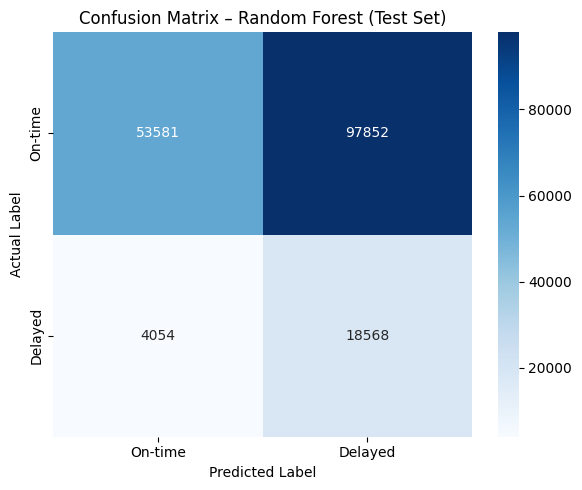

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, rf_test_preds)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["On-time", "Delayed"],
    yticklabels=["On-time", "Delayed"]
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – Random Forest (Test Set)")
plt.tight_layout()
plt.show()